In [1]:
%matplotlib inline

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE,KMeansSMOTE, ADASYN

import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Echonest audio features - IMBALANCED LEARNING
## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebooks:
- bin-genre_decision-tree_KNN  (section 2)

Sinci in our previous analysis we found out that both Decision Tree and KNN had higher performances with PCA, we decided to improve our results starting from those classifiers.

__________________________________
# 2 Binary genre - ROCK & JAZZ
__________________________________
## a) Import dataset

In [2]:
binclass_dataset = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/echo_features.csv')
binclass_dataset.set_index('track_id', inplace=True)
binclass_dataset.drop('listens',axis=1, inplace=True)
binclass_dataset.drop('comments',axis=1, inplace=True)
binclass_dataset = binclass_dataset[binclass_dataset['genre_top'].isin(['Rock','Jazz'])]
binclass_dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration,bit_rate
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,128.537,0.788251,Jazz,82,256
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452,Jazz,326,256
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,135.468,0.682397,Jazz,354,256
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,120.218,0.917613,Jazz,232,256
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock,405,256


[]

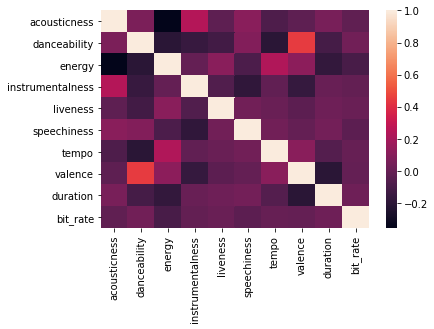

In [3]:
corr = binclass_dataset.corr()
sns.heatmap(corr)
plt.plot()

The highest correlation is the one between valence and danceability ***approximately 0.5***

In [4]:
print('Class distribution before balancing')
pd.concat(
    [binclass_dataset.genre_top.value_counts(),
                round(binclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing


,counts,percentage (%)
Rock,3892,94.17
Jazz,241,5.83


In [5]:
# Data preprocessing
le = preprocessing.LabelEncoder()
binclass_dataset['genre_top'] = le.fit_transform(binclass_dataset['genre_top'])
print('Legend:\n0: Jazz\n1: Rock')
# Define the labels
labels = binclass_dataset[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels[['genre_top']]

Legend:
0: Jazz
1: Rock


In [6]:
# remove labels from dataset
binclass_dataset.drop('genre_top', axis=1, inplace=True)

In [7]:
labels.head()

,genre_top
0,0
1,0
2,0
3,0
4,1


In [8]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(binclass_dataset)

## b) Compute PCA and plot distribution in 2D

In [9]:
# compute PCA using optimal number of components: 8 ( discovered in the notebook mentioned above)
pca = PCA(8,random_state=42)
pca.fit(scaled_features)
X_pca = pca.transform(scaled_features)

In [10]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_pca, labels, test_size=0.30, random_state=42, stratify=labels)

In [11]:
# development set shape
X.shape, y.shape

((2893, 8), (2893, 1))

In [12]:
# internal test shape
X_test.shape, y_test.shape

((1240, 8), (1240, 1))

In [13]:
print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing after splitting in train test


,counts,percentage (%)
genre_top,,
1,2724,94.16
0,169,5.84


In [14]:
# function for plotting data in 2D with PCA
def pca_2D(data, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = data[:,0]
    df['pca2'] = data[:,1]
    df['genres'] = le.inverse_transform(y)
    # plot scatter of PCA
    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='genres',
        palette={'Jazz':'darkblue','Rock':'red'},
        data=df,
        legend="full",
        alpha=0.8
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

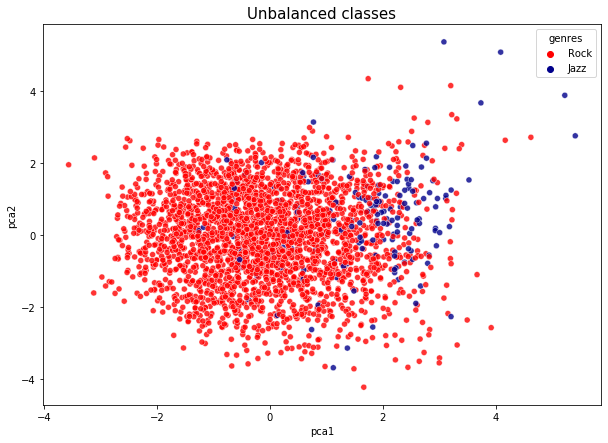

In [15]:
pca_2D(X, y,'Unbalanced classes')

## c) Imbalanced learning:
#### c.1) Undersampling - Random

In [16]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [17]:
print('Legend:\n0: Jazz\n1: Rock\nClass distribution after Random Undersampling:')
y_under.value_counts()

Legend:
0: Jazz
1: Rock
Class distribution after Random Undersampling:


genre_top
0            169
1            169
dtype: int64

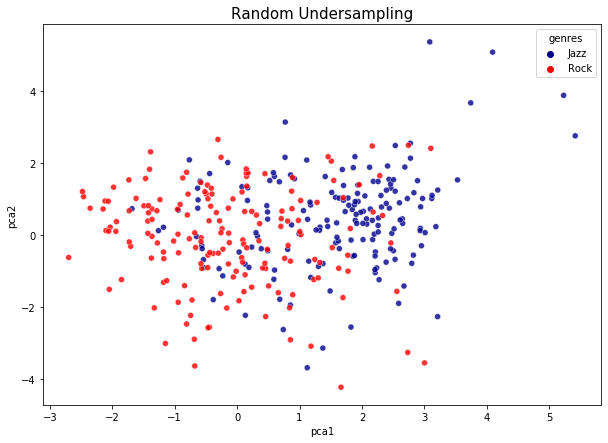

In [18]:
pca_2D(X_under,y_under,'Random Undersampling')

#### c.2) Condensed Nearest Neighbor (CNN)

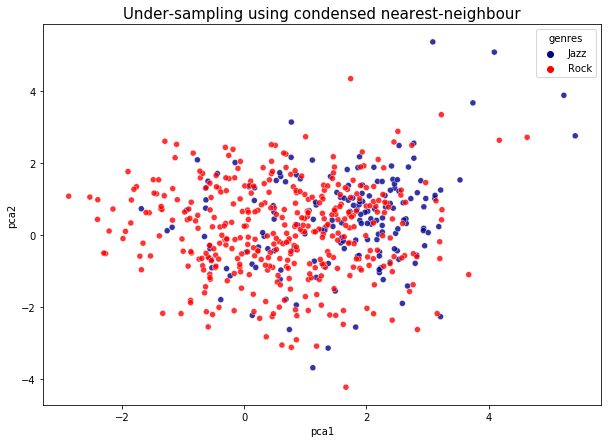

In [19]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

#### c.3) Tomek's Link

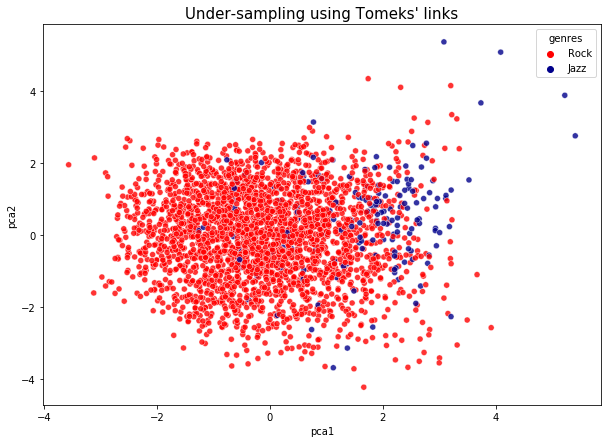

In [20]:
tomeks = TomekLinks()
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

#### c.4) Oversampling - Random

In [21]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)

In [22]:
X_over.shape, y_over.shape

((5448, 8), (5448, 1))

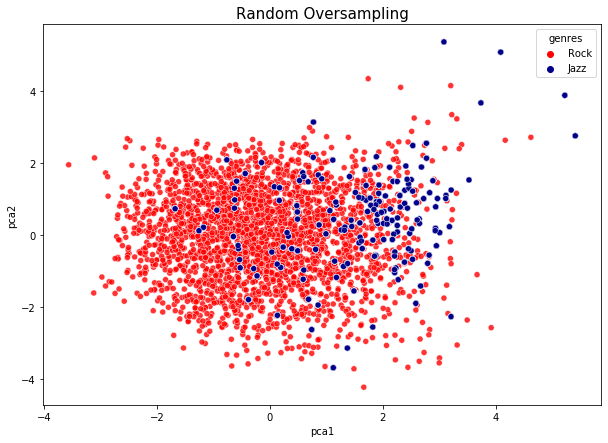

In [23]:
pca_2D(X_over, y_over, 'Random Oversampling')

#### c.5) SMOTE

In [24]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((5448, 8), (5448, 1))

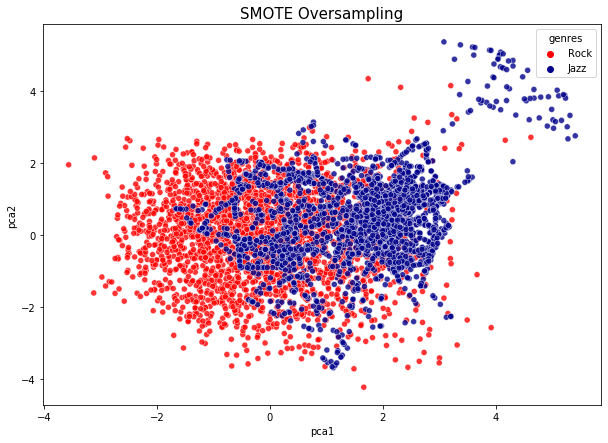

In [25]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

#### K-Means SMOTE

In [26]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=90, k_neighbors=5,cluster_balance_threshold=0)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)

In [27]:
y_ksmote.value_counts()

genre_top
0            2730
1            2724
dtype: int64

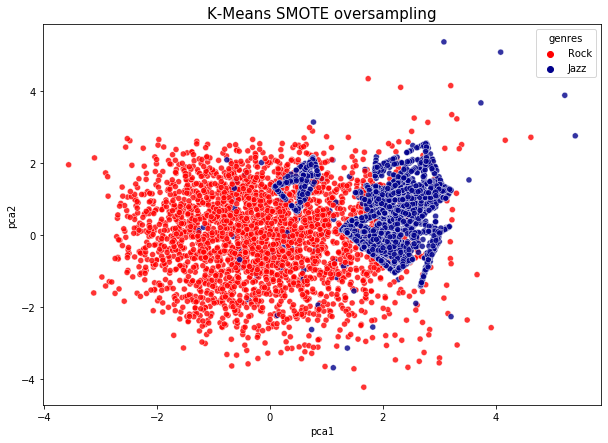

In [28]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

#### c.6) ADASYN

In [29]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

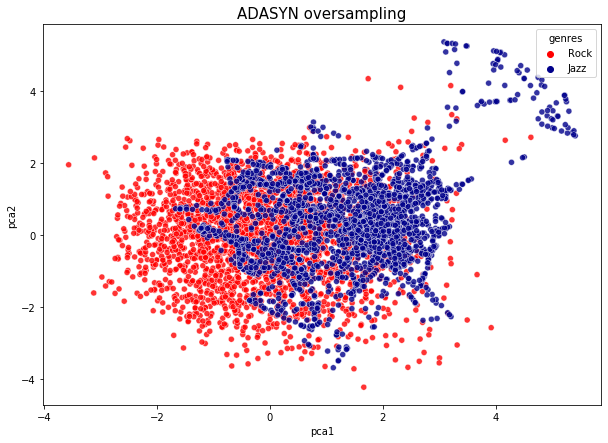

In [30]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

#### c.7) Class Weight

#### c.8) Ensamble (** not in the program)

_____________________________________________________________________________________________________________________

## d) Decision tree

### d.2) Unbalanced vs Balanced

In [31]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

roc_curves ={}
fpr_tpr = []
f1_scores_minc =[]

for bal_data,title in zip(data,titles):
    dt = DecisionTreeClassifier(criterion= 'entropy',max_depth=4, min_samples_leaf= 25,min_samples_split=20)
    dt.fit(bal_data[0],bal_data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    y_score = dt.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr.append((fpr,tpr))
    
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])

    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.942741935483871
F1-score [0.18390805 0.97033013]

Recall [0.11111111 0.99400685]
Precision [0.53333333 0.9477551 ]
              precision    recall  f1-score   support

           0       0.53      0.11      0.18        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.74      0.55      0.58      1240
weighted avg       0.92      0.94      0.92      1240

*** undersampling classification ***
Accuracy 0.6782258064516129
F1-score [0.21301775 0.79776989]

Recall [0.75       0.67380137]
Precision [0.12413793 0.97763975]
              precision    recall  f1-score   support

           0       0.12      0.75      0.21        72
           1       0.98      0.67      0.80      1168

    accuracy                           0.68      1240
   macro avg       0.55      0.71      0.51      1240
weighted avg       0.93      0.68      0.76      1240

*** condensed NN class

In [32]:
# classification with cost matrix
dt_w = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 20, min_samples_split=10, class_weight='balanced')
dt_w.fit(X, y)
y_pred_w = dt_w.predict(X_test)

# save f1 score of minority class
f1_scores_minc.append(f1_score(y_test, y_pred_w, average=None)[0])

print(f"*** cost-matrix classification ***")
print('Accuracy %s' % accuracy_score(y_test, y_pred_w))
print('F1-score %s\n' % f1_score(y_test, y_pred_w, average=None))
print(classification_report(y_test, y_pred_w))


*** cost-matrix classification ***
Accuracy 0.7556451612903226
F1-score [0.2406015  0.85439692]

              precision    recall  f1-score   support

           0       0.15      0.67      0.24        72
           1       0.97      0.76      0.85      1168

    accuracy                           0.76      1240
   macro avg       0.56      0.71      0.55      1240
weighted avg       0.93      0.76      0.82      1240



Text(0.5, 0, '')

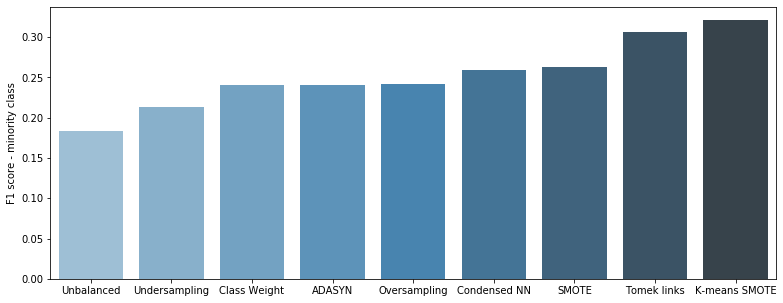

In [33]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN', 'Class Weight']


plt.figure(figsize=(13,5))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.xlabel(None)

### d.3) Compare results

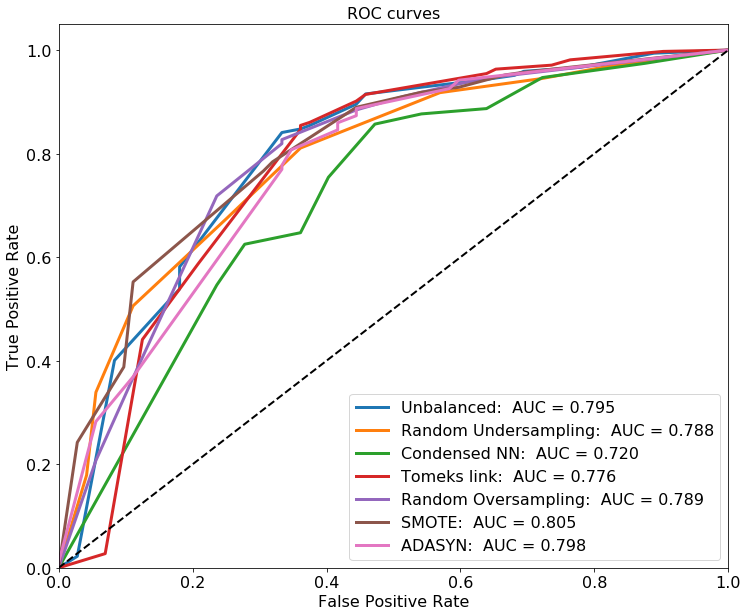

In [34]:
# plot roc curves
plt.figure(figsize=(12,10))

plt.plot(fpr_tpr[0][0], fpr_tpr[0][1], lw=3, label='Unbalanced:  AUC = %.3f' % roc_curves['unbalanced'])
plt.plot(fpr_tpr[1][0], fpr_tpr[1][1], lw=3, label='Random Undersampling:  AUC = %.3f' % roc_curves['undersampling'])
plt.plot(fpr_tpr[2][0], fpr_tpr[2][1], lw=3, label='Condensed NN:  AUC = %.3f' % roc_curves['condensed NN'])
plt.plot(fpr_tpr[3][0], fpr_tpr[3][1], lw=3, label='Tomeks link:  AUC = %.3f' % roc_curves['Tomek links'])
plt.plot(fpr_tpr[4][0], fpr_tpr[4][1], lw=3, label='Random Oversampling:  AUC = %.3f' % roc_curves['oversampling'])
plt.plot(fpr_tpr[5][0], fpr_tpr[5][1], lw=3, label='SMOTE:  AUC = %.3f' % roc_curves['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=3, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=16, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## d) KNN

### Unbalanced vs Balanced

In [35]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

roc_curves_knn ={}
fpr_tpr_knn = []
f1_scores_minc = []

for bal_data,title in zip(data,titles):
    knn = KNeighborsClassifier(n_neighbors = 8, weights='distance', metric='euclidean')
    knn.fit(bal_data[0],bal_data[1])
    y_pred = knn.predict(X_test)

    # computes roc curve for each classifier
    y_score = knn.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc_knn = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves_knn[title] = roc_auc_knn
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr_knn.append((fpr,tpr))
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])

    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.9443548387096774
F1-score [0.3030303  0.97102058]

              precision    recall  f1-score   support

           0       0.56      0.21      0.30        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.75      0.60      0.64      1240
weighted avg       0.93      0.94      0.93      1240

*** undersampling classification ***
Accuracy 0.8096774193548387
F1-score [0.29341317 0.89002796]

              precision    recall  f1-score   support

           0       0.19      0.68      0.29        72
           1       0.98      0.82      0.89      1168

    accuracy                           0.81      1240
   macro avg       0.58      0.75      0.59      1240
weighted avg       0.93      0.81      0.86      1240

*** condensed NN classification ***
Accuracy 0.9354838709677419
F1-score [0.35483871 0.96604414]

              precision    recall  f1-score   support

The condensed NearestNeighbor is the balancing technique yeilding the best results.<br>
The f1 score for class 0 goes from 0.24 to 0.38. This is due to the fact that **recall** improved as well, going from
0.15 in the unbalanced case (the classifier was not able to detect class 0) to 0.32 with the CNN. <br>
The precision decreses of few percent points (from 0.58 to 0.46) which is still acceptable considering the high recall.<br>
In terms of **recall**, **ADASYN** and **Random Undersampling** yeilded the highest recall (0.71 and 0.72 respectively). However after this rebalancing, although the f1 score increased to approximately 0.30, the precision of the model for that class resulted to be very low (0.19 for both). This means that in order to predict class 0 the classifier started to assign label 0 to more samples including those for which the real target was class 1.

Text(0.5, 0, '')

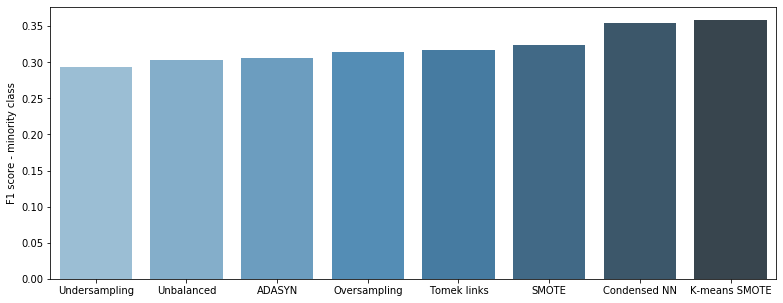

In [36]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN']


plt.figure(figsize=(13,5))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.xlabel(None)

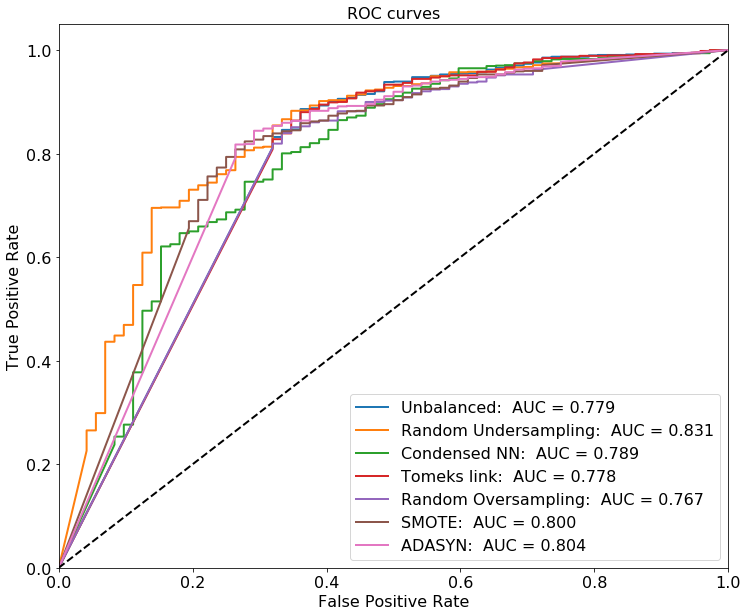

In [37]:
# plot roc curves
plt.figure(figsize=(12,10))

plt.plot(fpr_tpr_knn[0][0], fpr_tpr_knn[0][1], lw=2, label='Unbalanced:  AUC = %.3f' % roc_curves_knn['unbalanced'])
plt.plot(fpr_tpr_knn[1][0], fpr_tpr_knn[1][1], lw=2, label='Random Undersampling:  AUC = %.3f' % roc_curves_knn['undersampling'])
plt.plot(fpr_tpr_knn[2][0], fpr_tpr_knn[2][1], lw=2, label='Condensed NN:  AUC = %.3f' % roc_curves_knn['condensed NN'])
plt.plot(fpr_tpr_knn[3][0], fpr_tpr_knn[3][1], lw=2, label='Tomeks link:  AUC = %.3f' % roc_curves_knn['Tomek links'])
plt.plot(fpr_tpr_knn[4][0], fpr_tpr_knn[4][1], lw=2, label='Random Oversampling:  AUC = %.3f' % roc_curves_knn['oversampling'])
plt.plot(fpr_tpr_knn[5][0], fpr_tpr_knn[5][1], lw=2, label='SMOTE:  AUC = %.3f' % roc_curves_knn['SMOTE'])
plt.plot(fpr_tpr_knn[6][0], fpr_tpr_knn[6][1], lw=2, label='ADASYN:  AUC = %.3f' % roc_curves_knn['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=16, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()